In [1]:
!pip install torchsummary

In [1]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import seaborn as sns
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model

%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
data_dir = "../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
diseases = os.listdir(train_dir)

In [3]:
print("Total disease classes are: {}".format(len(diseases)))
print(diseases)

Total disease classes are: 38
['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', '

In [4]:
#This cell extract the number of unique plants and number of unique diseases
plants = set()  #a set for unique plants
NumberOfDiseases = sum(1 for plant in diseases if 'healthy' not in plant.split('___')[1])

for plant in diseases:
    plants.add(plant.split('___')[0])  # Sets handle duplicates automatically

# Convert `plants` back to a list if needed
plants = list(plants)


In [5]:
print("Number Unique of plants: {}".format(len(plants)))
print(f"\nUnique Plants are: \n{plants}")
print("\n\nNumber of Unique diseases: {}".format(NumberOfDiseases))

Number Unique of plants: 14

Unique Plants are: 
['Orange', 'Blueberry', 'Squash', 'Pepper,_bell', 'Potato', 'Strawberry', 'Grape', 'Soybean', 'Corn_(maize)', 'Apple', 'Cherry_(including_sour)', 'Peach', 'Raspberry', 'Tomato']


Number of Unique diseases: 26


In [6]:
# Number of images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

no. of images
Tomato___Late_blight                                         1851
Tomato___healthy                                             1926
Grape___healthy                                              1692
Orange___Haunglongbing_(Citrus_greening)                     2010
Soybean___healthy                                            2022
Squash___Powdery_mildew                                      1736
Potato___healthy                                             1824
Corn_(maize)___Northern_Leaf_Blight                          1908
Tomato___Early_blight                                        1920
Tomato___Septoria_leaf_spot                                  1745
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot           1642
Strawberry___Leaf_scorch                                     1774
Peach___healthy                                              1728
Apple___Apple_scab                                           2016
Tomato___Tomato_Yellow_Leaf_Curl_Virus                       1961
Tomato___Bacterial_spot                                      1702
Apple___Black_rot                                            1987
Blueberry___healthy                                          1816
Cherry_(including_sour)___Powdery_mildew                     1683
Peach___Bacterial_spot                                       1838
Apple___Cedar_apple_rust                                     1760
Tomato___Target_Spot                                         1827
Pepper,_bell___healthy                                       1988
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)                   1722
Potato___Late_blight                                         1939
Tomato___Tomato_mosaic_virus                                 1790
Strawberry___healthy                                         1824
Apple___healthy                                              2008
Grape___Black_rot                                            1888
Potato___Early_blight                                        1939
Cherry_(including_sour)___healthy                            1826
Corn_(maize)___Common_rust_                                  1907
Grape___Esca_(Black_Measles)                                 1920
Raspberry___healthy                                          1781
Tomato___Leaf_Mold                                           1882
Tomato___Spider_mites Two-spotted_spider_mite                1741
Pepper,_bell___Bacterial_spot                                1913
Corn_(maize)___healthy                                       1859

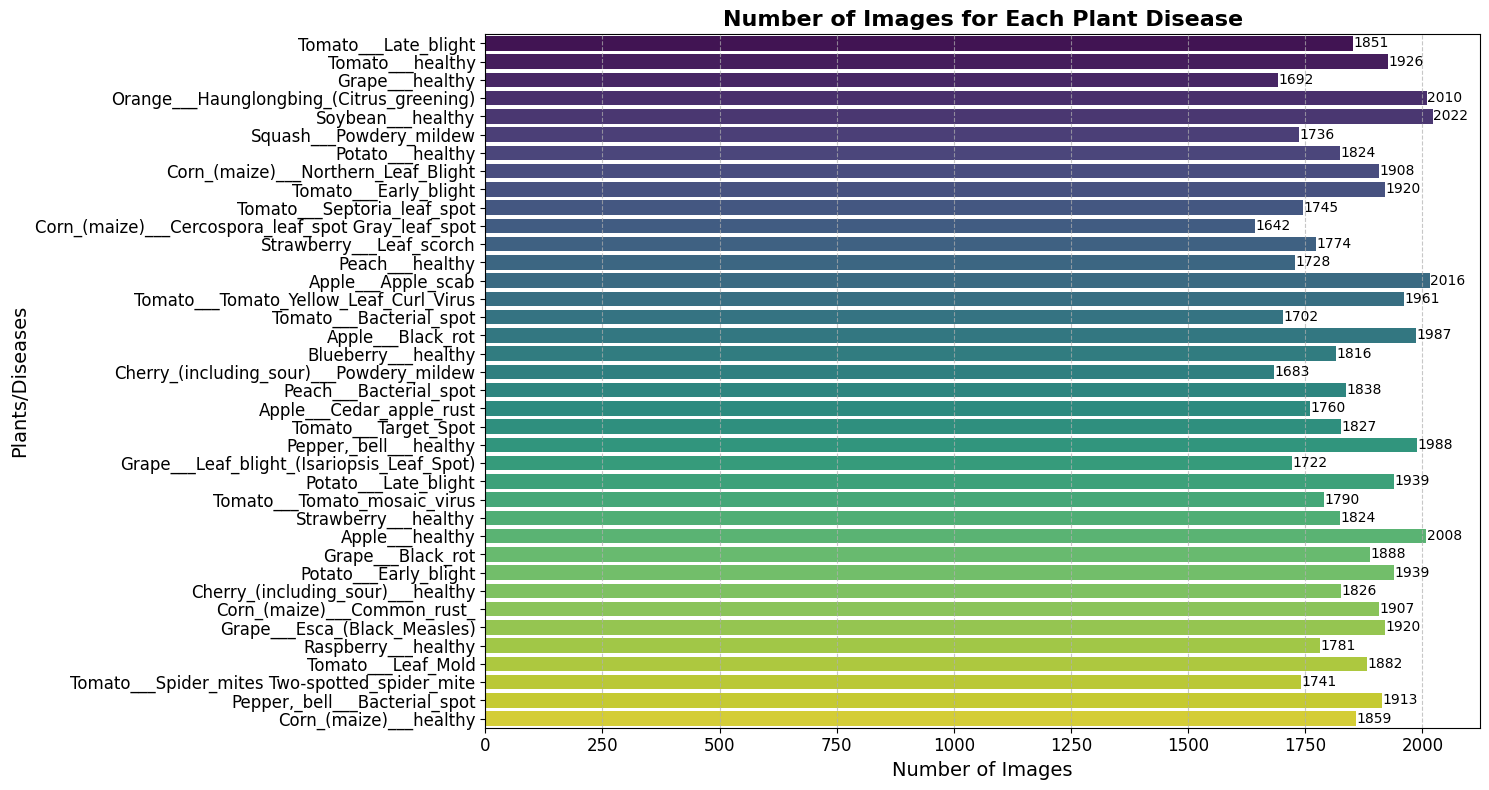

In [7]:


# Assuming `nums` is a dictionary with disease names as keys and image counts as values
diseases = list(nums.keys())
image_counts = list(nums.values())

# Create the plot
plt.figure(figsize=(15, 8))
sns.barplot(y=diseases, x=image_counts, palette="viridis")

# Add data labels
for i, count in enumerate(image_counts):
    plt.text(count + 1, i, str(count), va='center', fontsize=10, color='black')

# Customize plot aesthetics
plt.xlabel('Number of Images', fontsize=14)
plt.ylabel('Plants/Diseases', fontsize=14)
plt.title('Number of Images for Each Plant Disease', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Images Available for training

In [8]:
n_train = sum(nums.values())
print(f"There are {n_train} images for training")


There are 70295 images for training


Data Preparation for training

In [9]:
# datasets for validation and training
# Train dataset with more augmentation techniques
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.ToTensor()
])

# Validation dataset with only resizing and normalization
valid_transform = transforms.Compose([
    transforms.Resize(256),  # Resize to 256x256
    transforms.ToTensor()    # Convert to tensor
])

# Load datasets
train = ImageFolder(train_dir, transform=train_transform)
valid = ImageFolder(valid_dir, transform=valid_transform)

In [10]:
img, label = train[0]
print(img.shape, label)

torch.Size([3, 256, 256]) 0


In [11]:
# total number of classes in train set
len(train.classes)

38

In [12]:
# for checking some images from training dataset
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

Label :Apple___Apple_scab(0)


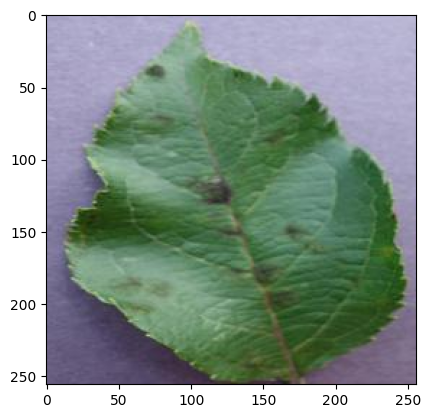

In [13]:
show_image(*train[0])

Label :Peach___Bacterial_spot(16)


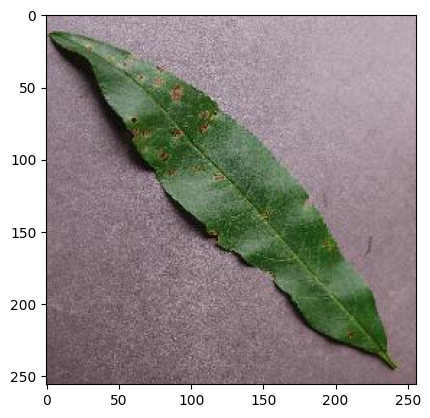

In [14]:
show_image(*train[30000])

In [15]:
# Setting the seed value
random_seed = 7
torch.manual_seed(random_seed)

In [16]:
# setting the batch size
batch_size = 32

In [17]:
# DataLoaders for training and validation
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

In [18]:
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break


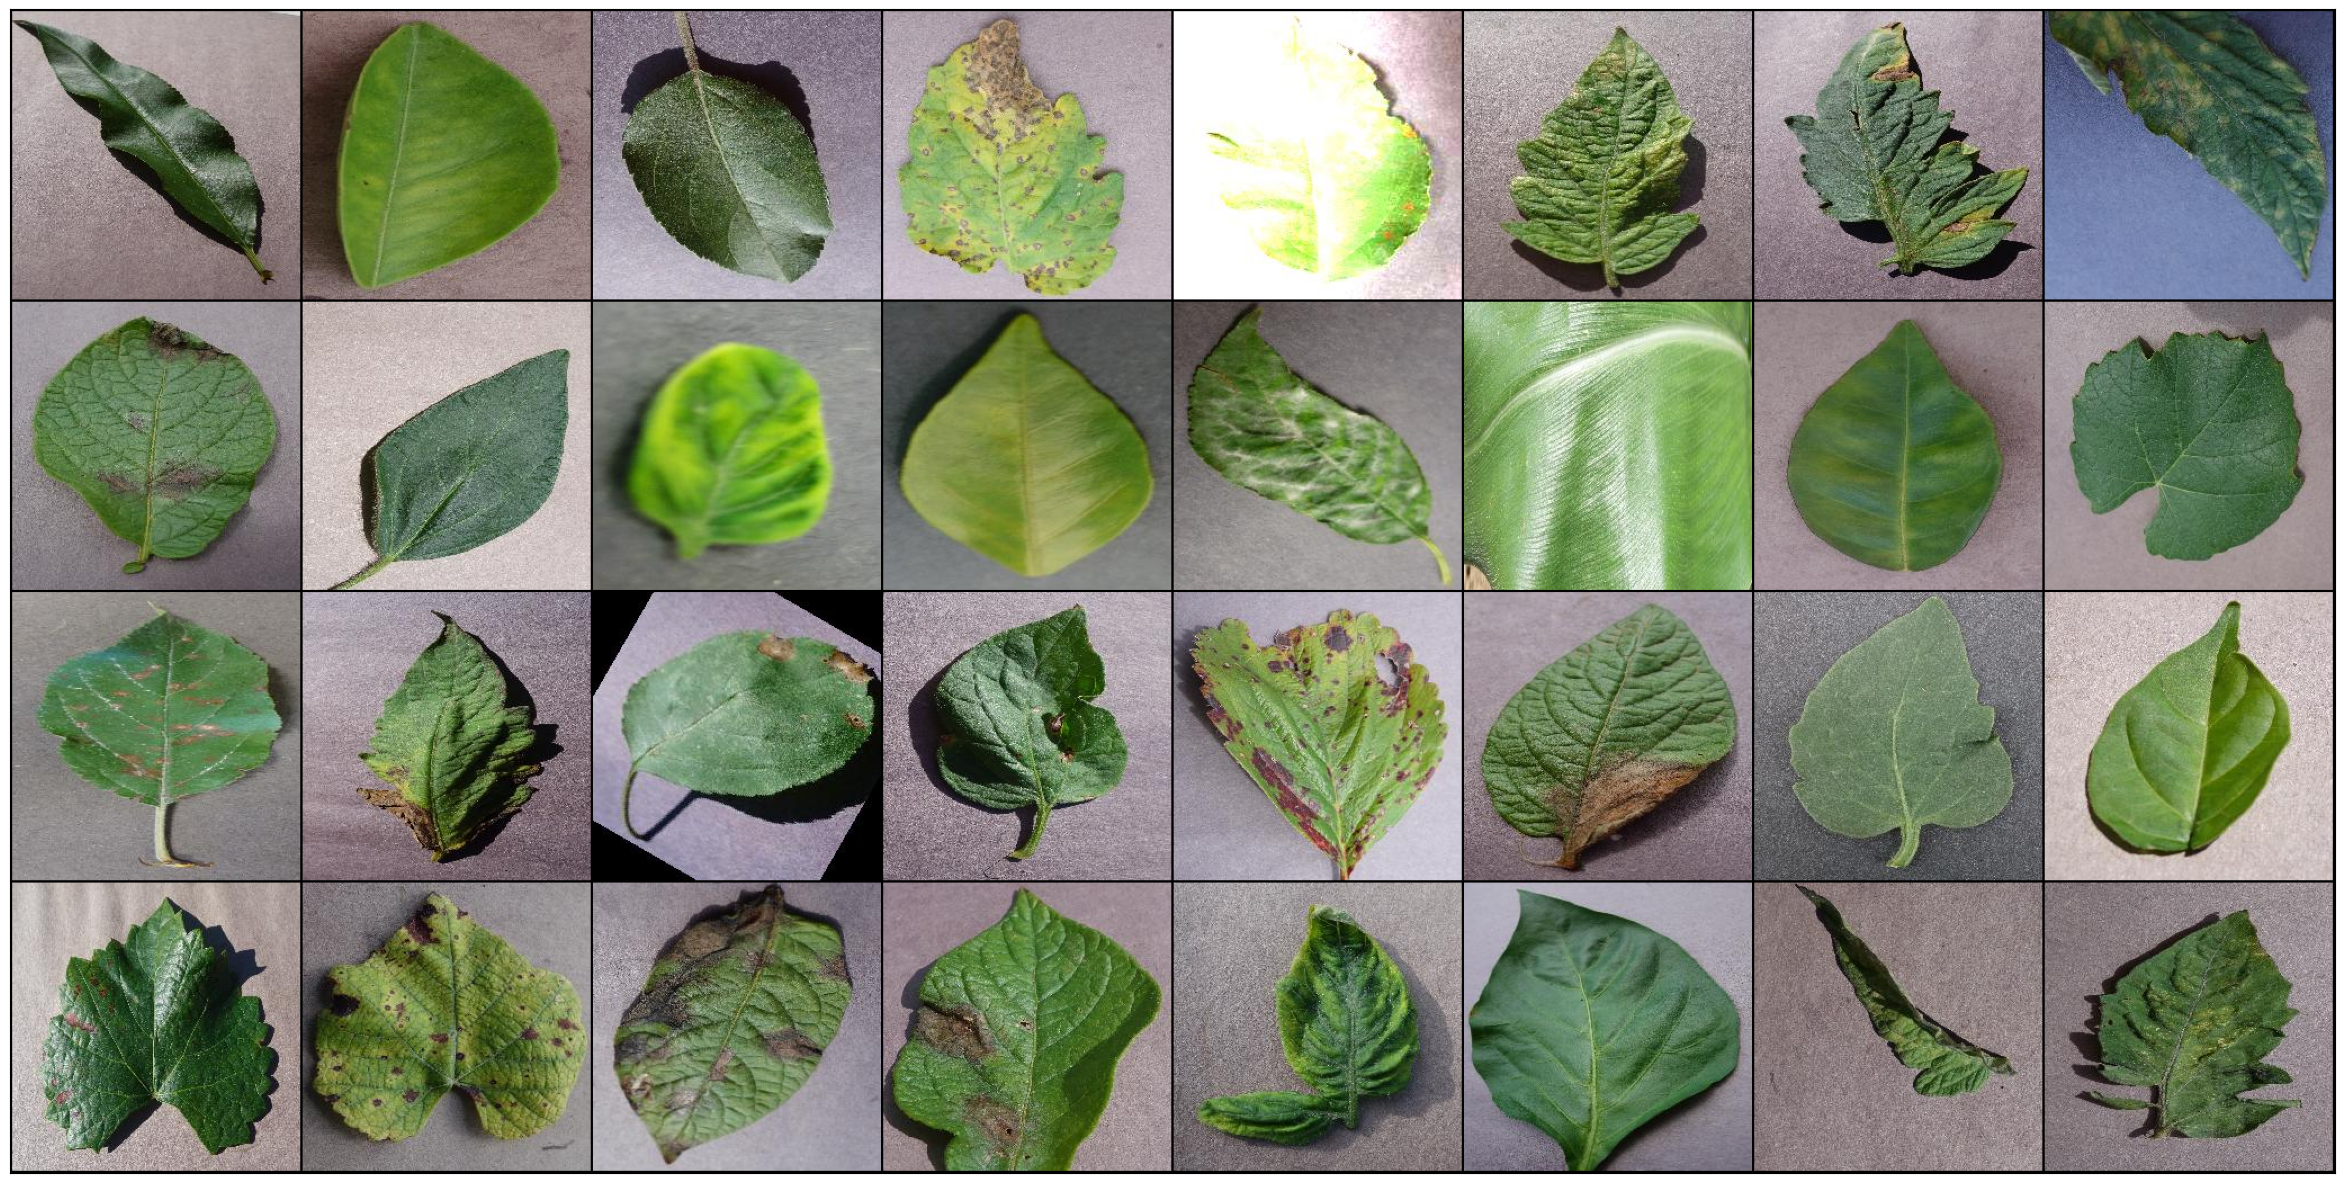

In [19]:
# Images for first batch of training
show_batch(train_dl)

In [20]:

# Function to select the appropriate device (GPU if available, otherwise CPU)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():  # Check for GPU availability
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# Function to move data (either a tensor, list, or tuple) to the selected device
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        # If data is a list/tuple, move each element to the device
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)  # Move tensor to device

# Custom DataLoader class that moves data to device during iteration
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl  # Original DataLoader
        self.device = device  # Device (CPU or GPU)
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)  # Move batch to the device
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)





In [21]:
# Select the appropriate device (GPU or CPU)
device = get_default_device()
print(f'Using device: {device}')



Using device: cuda


In [22]:
# Now wrap the train and validation DataLoaders with the custom DeviceDataLoader
train_dl = DeviceDataLoader(train_dl, device)  # Wrap train DataLoader
valid_dl = DeviceDataLoader(valid_dl, device)  # Wrap validation DataLoader

Build the model architecture

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Simple residual block
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x

# Function to calculate accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Base class for image classification models
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.tensor(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))

# Convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    ]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)

# Kolmogorov-Arnold network implementation
class KolmogorovArnoldNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.hidden_layer = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layer(x)
        x = self.output_layer(x)
        return x

# ResNet architecture
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()

        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64 
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))

        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 4
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))

        # Incorporating Kolmogorov-Arnold network
        self.kanet = KolmogorovArnoldNetwork(input_dim=512, hidden_dim=256, output_dim=num_diseases)

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            self.kanet
        )

    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out


In [24]:
# defining the model and moving it to the GPU
model = to_device(ResNet9(3, len(train.classes)), device) 
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [25]:
INPUT_SHAPE = (3, 256, 256)
print(summary(model.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

In [26]:
#for training: 
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                 grad_clip=None, opt_func=torch.optim.SGD, patience=2):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Scheduler for one-cycle learning rate
    sched = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader)
    )
    
    best_val_loss = float('inf')  # Initialize best validation loss
    no_improvement_count = 0     # Count epochs with no improvement in val_loss
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_losses = []
        train_accuracies = []
        lrs = []
        
        for batch in train_loader:
            # Training step
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Compute training accuracy for the batch
            images, labels = batch
            images, labels = images.cuda(), labels.cuda()
            predictions = model(images)
            batch_acc = accuracy(predictions, labels)
            train_accuracies.append(batch_acc.item())
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            # Recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = torch.tensor(train_accuracies).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
        # Early stopping check
        if result['val_loss'] < best_val_loss:
            best_val_loss = result['val_loss']
            no_improvement_count = 0  # Reset counter if val_loss improves
        else:
            no_improvement_count += 1  # Increment counter if no improvement
        
        if no_improvement_count >= patience:
            print(f"Stopping early at epoch {epoch + 1} due to no improvement in validation loss.")
            break  # Stop training if validation loss doesn't improve
    
    return history

In [27]:
%%time
history = [evaluate(model, valid_dl)]
history

CPU times: user 1min 21s, sys: 5.3 s, total: 1min 26s
Wall time: 1min 19s


[{'val_loss': tensor(3.6376, device='cuda:0'), 'val_accuracy': tensor(0.0247)}]

In [28]:
epochs = 2
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [29]:
%%time
history += fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=1e-4, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00812, train_loss: 1.4913, val_loss: 0.4941, val_acc: 0.8447
Epoch [1], last_lr: 0.00000, train_loss: 0.4206, val_loss: 0.0845, val_acc: 0.9730
CPU times: user 53min 16s, sys: 52 s, total: 54min 8s
Wall time: 52min 51s


In [39]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    # Ensure tensors are moved to the CPU and converted to NumPy arrays
    train_losses = [x.get('train_loss').cpu().numpy() if isinstance(x.get('train_loss'), torch.Tensor) else x.get('train_loss') for x in history]
    val_losses = [x['val_loss'].cpu().numpy() if isinstance(x['val_loss'], torch.Tensor) else x['val_loss'] for x in history]
    
    import matplotlib.pyplot as plt
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

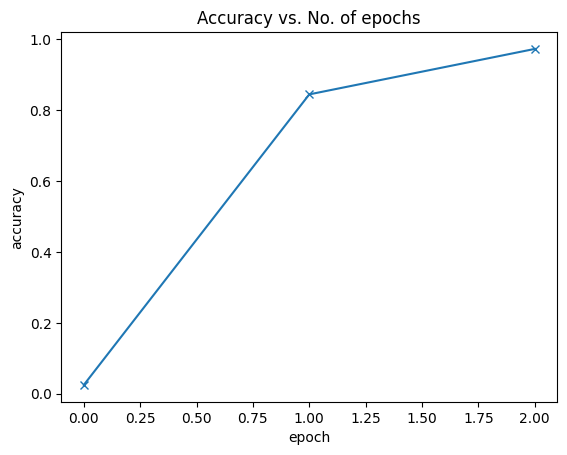

In [32]:
plot_accuracies(history)

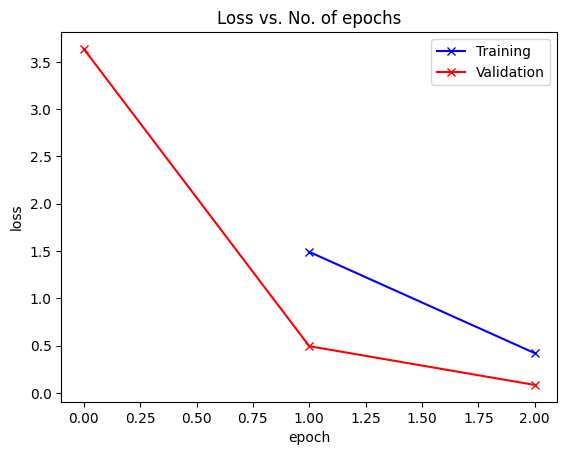

In [40]:
plot_losses(history)

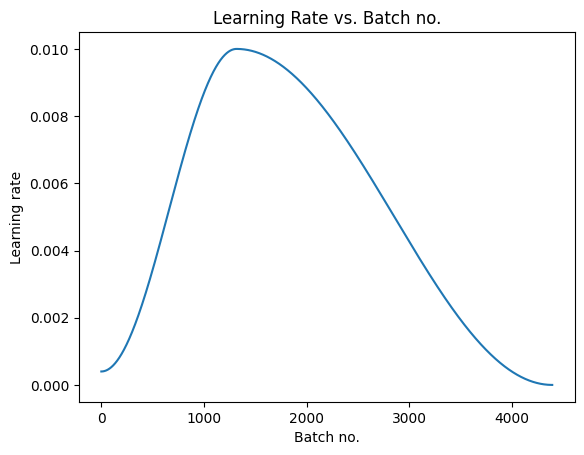

In [36]:
plot_lrs(history)

In [37]:
# saving to the kaggle working directory
PATH = './plant-disease-model.pth'  
torch.save(model.state_dict(), PATH)

In [38]:
# saving the entire model to working directory
PATH = './plant-disease-model-complete.pth'
torch.save(model, PATH)

In [ ]:
# SimpleResidualBlock - for ResNet-style residual learning
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [ ]:
# KAN Linear Layer (Univariate Transformation)
class KANLinear(nn.Module):
    def __init__(self, in_dim, out_dim, grid_size=5):
        super(KANLinear, self).__init__()
        self.grid_size = grid_size
        self.weights = nn.Parameter(torch.randn(grid_size, in_dim, out_dim))
        self.biases = nn.Parameter(torch.randn(grid_size, out_dim))

    def forward(self, x):
        # x: [batch_size, in_dim]
        activations = [torch.sin(torch.matmul(x, self.weights[i]) + self.biases[i]) for i in range(self.grid_size)]
        output = torch.stack(activations, dim=2)  # [batch_size, out_dim, grid_size]
        return output.mean(dim=2)  # Aggregate over grid


# KAN Linear 2 Layer (Summation)
class KANLinear2(nn.Module):
    def __init__(self, in_dim, out_dim, grid_size=5):
        super(KANLinear2, self).__init__()
        self.grid_size = grid_size
        self.weights = nn.Parameter(torch.randn(grid_size, in_dim, out_dim))
        self.biases = nn.Parameter(torch.randn(grid_size, out_dim))

    def forward(self, x):
        # x: [batch_size, in_dim]
        activations = [F.relu(torch.matmul(x, self.weights[i]) + self.biases[i]) for i in range(self.grid_size)]
        output = torch.stack(activations, dim=2)  # [batch_size, out_dim, grid_size]
        return output.mean(dim=2)  # Aggregate over grid


# KAN Conv2d Layer
class KANConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(KANConv2d, self).__init__()
        self.kernel_size = kernel_size
        self.conv_weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))
        self.bias = nn.Parameter(torch.randn(out_channels))
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        # x: [batch_size, in_channels, height, width]
        conv_output = F.conv2d(x, self.conv_weight, self.bias, stride=self.stride, padding=self.padding)
        return torch.sin(conv_output)  # Apply KAN-style non-linearity


# ConvBlock (Standard Convolution + Batch Normalization)
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


In [ ]:
# Accuracy calculation utility
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# Base class for image classification models
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))


In [ ]:
# ConvBlock (Standard Convolution + Batch Normalization)
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


# ResNet9 with KAN Components
class ResNet9WithKAN(nn.Module):
    def __init__(self, in_channels, num_diseases, use_kan=True):
        super().__init__()
        
        # First Convolutional Layer
        self.conv1 = ConvBlock(in_channels, 64) if not use_kan else KANConv2d(in_channels, 64, kernel_size=3, padding=1)
        
        # Second Convolutional Layer
        self.conv2 = ConvBlock(64, 128, pool=True) if not use_kan else KANConv2d(64, 128, kernel_size=3, padding=1, stride=2)
        
        # Residual Block 1
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128)) if not use_kan else nn.Sequential(
            KANConv2d(128, 128, kernel_size=3, padding=1),
            KANConv2d(128, 128, kernel_size=3, padding=1)
        )
        
        # Third Convolutional Layer
        self.conv3 = ConvBlock(128, 256, pool=True) if not use_kan else KANConv2d(128, 256, kernel_size=3, padding=1, stride=2)
        
        # Fourth Convolutional Layer
        self.conv4 = ConvBlock(256, 512, pool=True) if not use_kan else KANConv2d(256, 512, kernel_size=3, padding=1, stride=2)
        
        # Residual Block 2
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512)) if not use_kan else nn.Sequential(
            KANConv2d(512, 512, kernel_size=3, padding=1),
            KANConv2d(512, 512, kernel_size=3, padding=1)
        )

        # Output Layer
        self.classifier = nn.Sequential(nn.MaxPool2d(4), nn.Flatten())

        # Kolmogorov-Arnold Network (KAN) Layers
        self.univariate_layer = nn.Sequential(
            nn.Linear(512 * 16 * 16, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512)
        ) if not use_kan else nn.Sequential(
            KANLinear(in_dim=512 * 16 * 16, out_dim=1024, grid_size=7),
            nn.ReLU(),
            KANLinear(in_dim=1024, out_dim=512, grid_size=7)
        )

        # Final Output Layer
        self.summation_layer = nn.Sequential(
            nn.Linear(512, num_diseases)
        ) if not use_kan else nn.Sequential(
            KANLinear2(in_dim=512, out_dim=num_diseases, grid_size=5)
        )

    def forward(self, xb):  # xb is the loaded batch
        # Pass through the network layers
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out

        # Classifier Step 1: Global Pooling and Flattening
        out = self.classifier(out)

        # KAN Step
        out = self.univariate_layer(out)  # Apply univariate transformations
        out = self.summation_layer(out)   # Final output layer

        return out

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# KAN Linear Layer (Univariate Transformation)
class KANLinear(nn.Module):
    def __init__(self, in_dim, out_dim, grid_size=5):
        super(KANLinear, self).__init__()
        self.grid_size = grid_size
        self.weights = nn.Parameter(torch.randn(grid_size, in_dim, out_dim))
        self.biases = nn.Parameter(torch.randn(grid_size, out_dim))

    def forward(self, x):
        # x: [batch_size, in_dim]
        activations = [torch.sin(torch.matmul(x, self.weights[i]) + self.biases[i]) for i in range(self.grid_size)]
        output = torch.stack(activations, dim=2)  # [batch_size, out_dim, grid_size]
        return output.mean(dim=2)  # Aggregate over grid


# KAN Linear 2 Layer (Summation)
class KANLinear2(nn.Module):
    def __init__(self, in_dim, out_dim, grid_size=5):
        super(KANLinear2, self).__init__()
        self.grid_size = grid_size
        self.weights = nn.Parameter(torch.randn(grid_size, in_dim, out_dim))
        self.biases = nn.Parameter(torch.randn(grid_size, out_dim))

    def forward(self, x):
        # x: [batch_size, in_dim]
        activations = [F.relu(torch.matmul(x, self.weights[i]) + self.biases[i]) for i in range(self.grid_size)]
        output = torch.stack(activations, dim=2)  # [batch_size, out_dim, grid_size]
        return output.mean(dim=2)  # Aggregate over grid


# KAN Conv2d Layer
class KANConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(KANConv2d, self).__init__()
        self.kernel_size = kernel_size
        self.conv_weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))
        self.bias = nn.Parameter(torch.randn(out_channels))
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        # x: [batch_size, in_channels, height, width]
        conv_output = F.conv2d(x, self.conv_weight, self.bias, stride=self.stride, padding=self.padding)
        return torch.sin(conv_output)  # Apply KAN-style non-linearity


# ConvBlock (Standard Convolution + Batch Normalization)
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


# SimpleResidualBlock - for ResNet-style residual learning
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x  # ReLU can be applied before or after adding the input


# Accuracy calculation utility
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# Base class for image classification models
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))


# ResNet9 with KAN Components
class ResNet9WithKAN(nn.Module):
    def __init__(self, in_channels, num_diseases, use_kan=True):
        super().__init__()
        
        # First Convolutional Layer
        self.conv1 = ConvBlock(in_channels, 64) if not use_kan else KANConv2d(in_channels, 64, kernel_size=3, padding=1)
        
        # Second Convolutional Layer
        self.conv2 = ConvBlock(64, 128, pool=True) if not use_kan else KANConv2d(64, 128, kernel_size=3, padding=1, stride=2)
        
        # Residual Block 1
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128)) if not use_kan else nn.Sequential(
            KANConv2d(128, 128, kernel_size=3, padding=1),
            KANConv2d(128, 128, kernel_size=3, padding=1)
        )
        
        # Third Convolutional Layer
        self.conv3 = ConvBlock(128, 256, pool=True) if not use_kan else KANConv2d(128, 256, kernel_size=3, padding=1, stride=2)
        
        # Fourth Convolutional Layer
        self.conv4 = ConvBlock(256, 512, pool=True) if not use_kan else KANConv2d(256, 512, kernel_size=3, padding=1, stride=2)
        
        # Residual Block 2
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512)) if not use_kan else nn.Sequential(
            KANConv2d(512, 512, kernel_size=3, padding=1),
            KANConv2d(512, 512, kernel_size=3, padding=1)
        )

        # Output Layer
        self.classifier = nn.Sequential(nn.MaxPool2d(4), nn.Flatten())

        # Kolmogorov-Arnold Network (KAN) Layers
        self.univariate_layer = nn.Sequential(
            nn.Linear(512 * 16 * 16, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512)
        ) if not use_kan else nn.Sequential(
            KANLinear(in_dim=512 * 16 * 16, out_dim=1024, grid_size=7),
            nn.ReLU(),
            KANLinear(in_dim=1024, out_dim=512, grid_size=7)
        )

        # Final Output Layer
        self.summation_layer = nn.Sequential(
            nn.Linear(512, num_diseases)
        ) if not use_kan else nn.Sequential(
            KANLinear2(in_dim=512, out_dim=num_diseases, grid_size=5)
        )

    def forward(self, xb):  # xb is the loaded batch
        # Pass through the network layers
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out

        # Classifier Step 1: Global Pooling and Flattening
        out = self.classifier(out)

        # KAN Step
        out = self.univariate_layer(out)  # Apply univariate transformations
        out = self.summation_layer(out)   # Final output layer

        return out
